In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from itertools import cycle
from io import StringIO
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

6.378363740283615 11.378363740283614 left-right threshold
Label 4 is oriented Vertical
[[34], [33], [32], [31], [30], [29]] patch summary


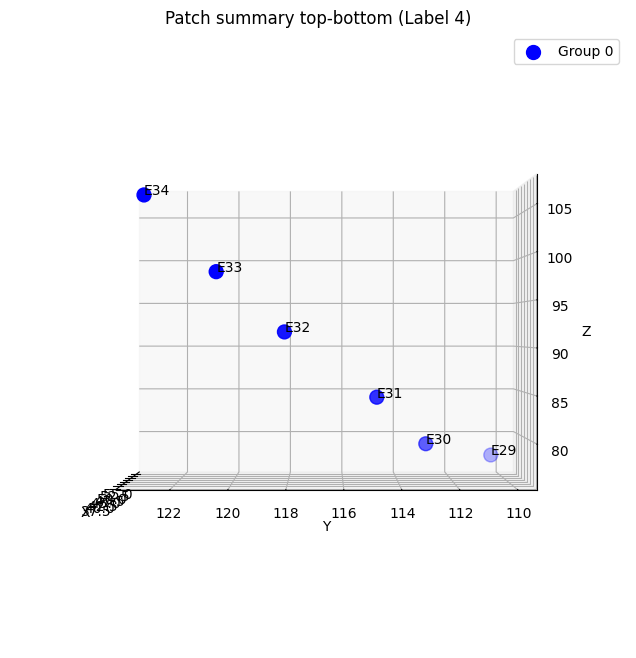

3.8315511673441667 8.831551167344166 left-right threshold
Label 2 is oriented Vertical
[[36, 35], [47, 46, 45]] patch summary


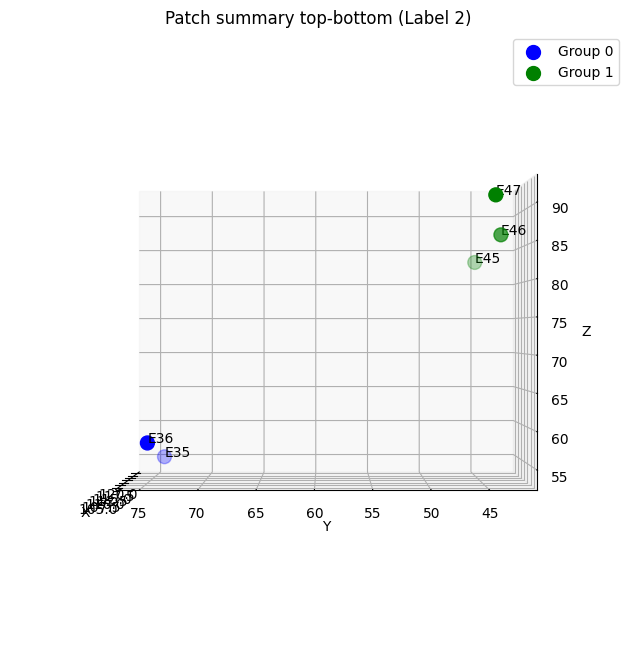

7.149280367063982 12.149280367063982 left-right threshold
Label 9 is oriented Vertical
[[42], [41], [40], [39], [38], [37]] patch summary


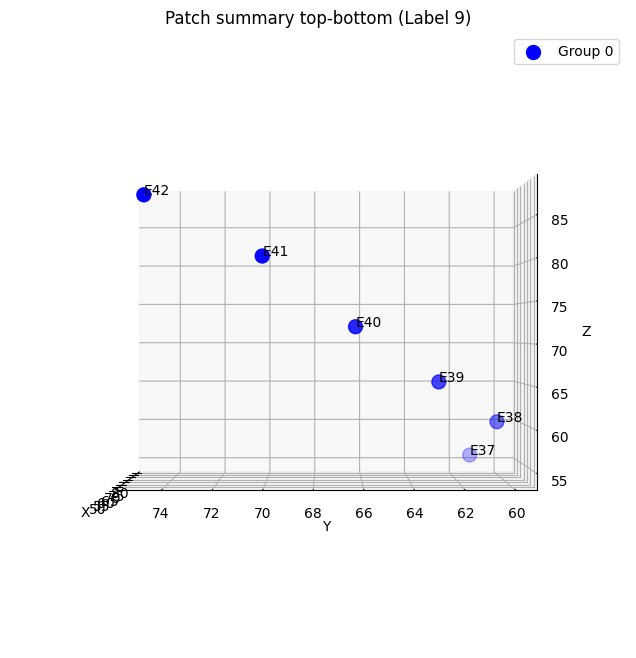

8.259699880433448 13.259699880433448 left-right threshold
Label 1 is oriented Horizontal
[124, 123, 122, 121] patch summary
[117, 116, 115, 114, 113] patch summary
[108, 107, 106, 105] patch summary
[100, 99, 98, 44, 43, 97] patch summary


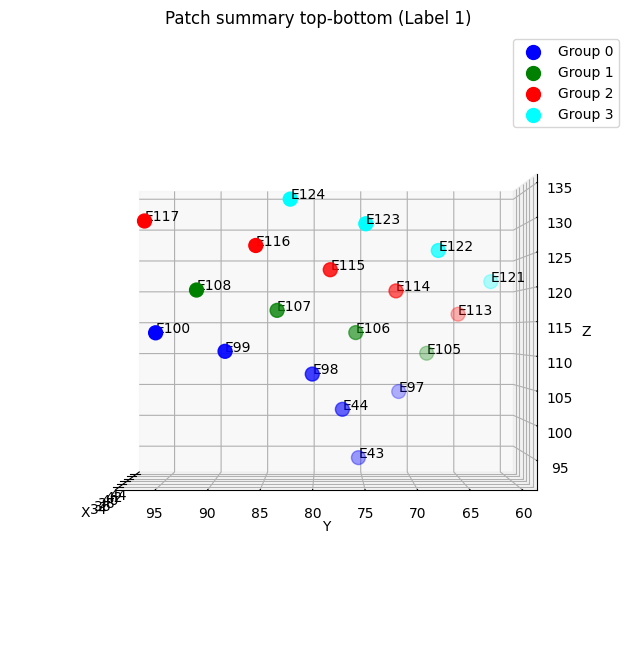

6.202938267456767 11.202938267456766 left-right threshold
Label 6 is oriented Vertical
[[54], [53], [52], [51], [50], [49], [48]] patch summary


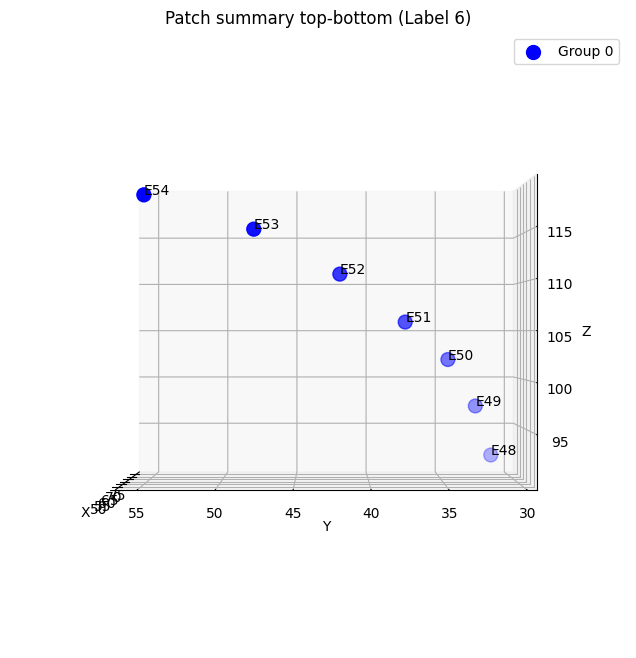

8.182795165518002 13.182795165518002 left-right threshold
Label 0 is oriented Vertical
[[59, 58, 57, 56, 55], [64, 63, 62, 61, 60]] patch summary


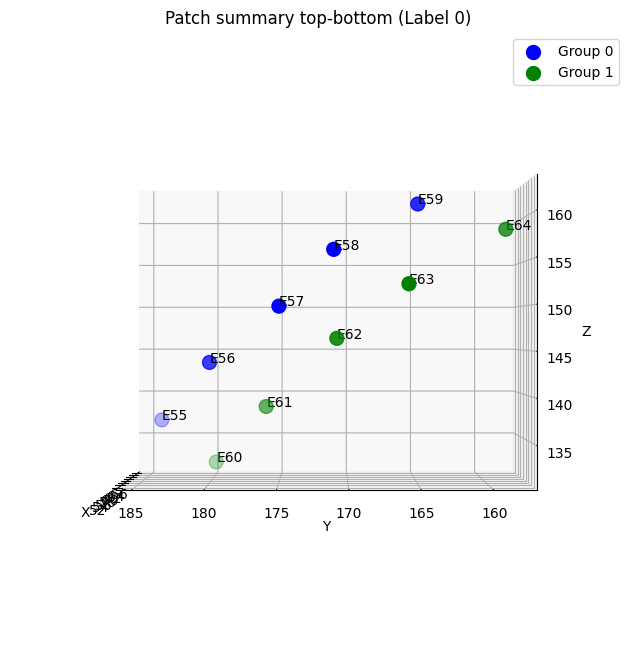

10.196785832274523 15.196785832274523 left-right threshold
Label 3 is oriented Horizontal
[92, 91, 90, 89] patch summary
[84, 83, 82, 81] patch summary
[76, 75, 74, 73] patch summary
[68, 67, 66, 65] patch summary


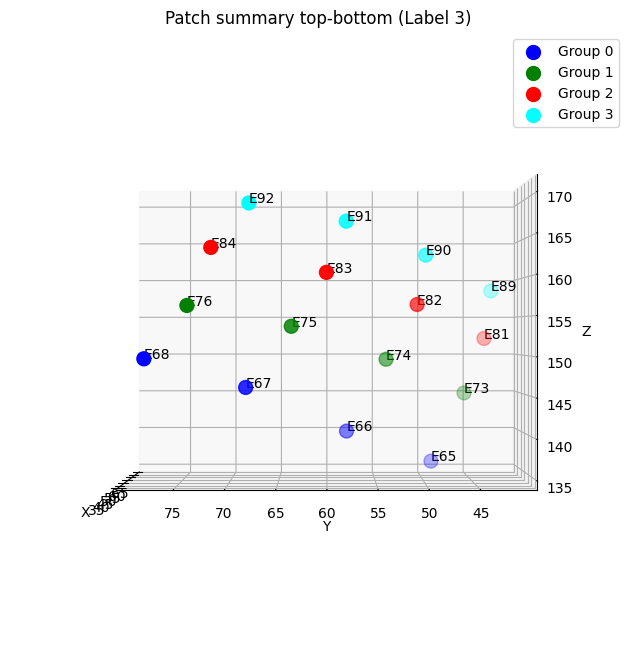

10.31962740741738 15.31962740741738 left-right threshold
Label 7 is oriented Horizontal
[96, 95, 94, 93] patch summary
[88, 87, 86, 85] patch summary
[80, 79, 78, 77] patch summary
[72, 71, 70, 69] patch summary


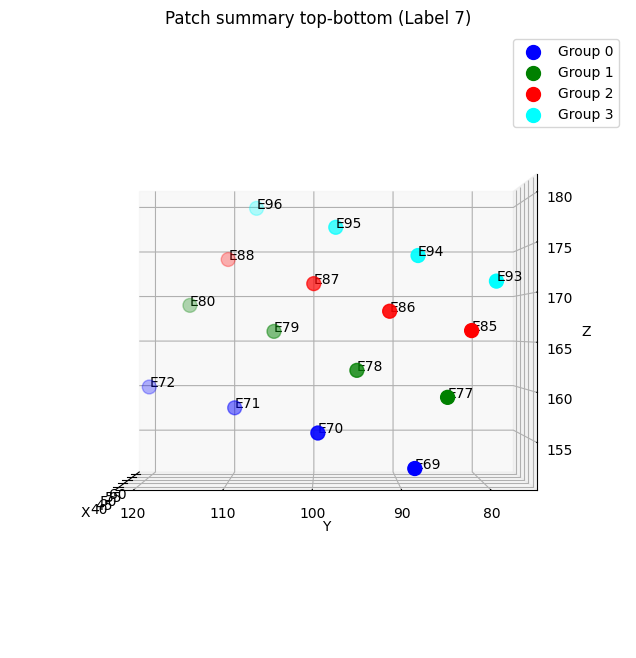

10.95603533444105 15.95603533444105 left-right threshold
Label 5 is oriented Horizontal
[120, 119, 118] patch summary
[112, 111, 110, 109] patch summary
[104, 103, 102, 101] patch summary


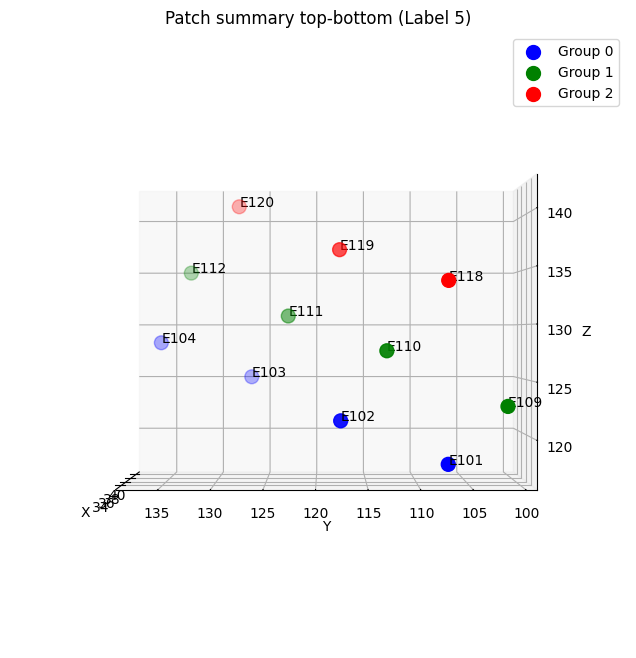

6.086530248354919 14.086530248354919 top-bottom threshold
Label 10 is oriented Vertical
[[11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [27, 28]] patch summary


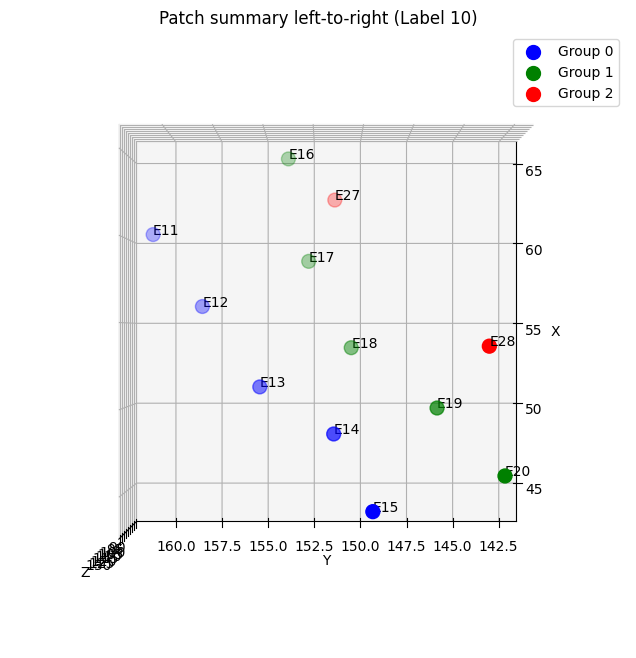

8.83648225487345 16.836482254873452 top-bottom threshold
Label 8 is oriented Horizontal
[26, 25, 24, 23, 22, 21] patch summary


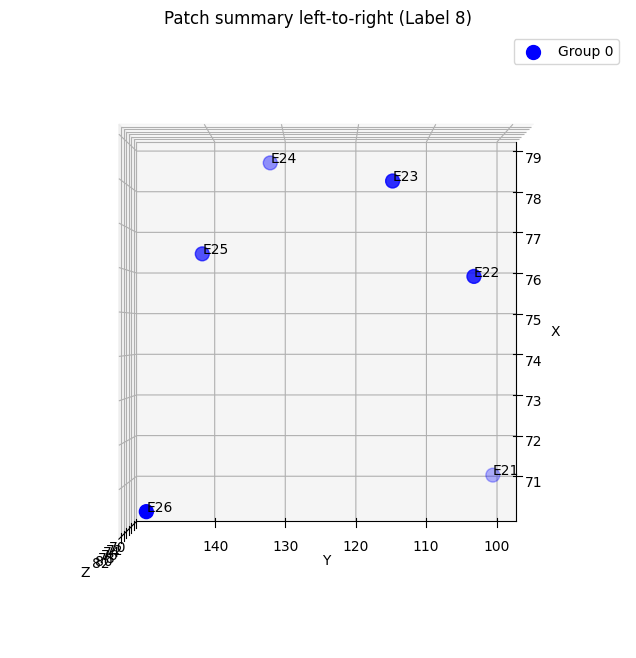

{'4': {'view': 'left-right',
  'orientation': 'Vertical',
  'matrix': [[34], [33], [32], [31], [30], [29]]},
 '2': {'view': 'left-right',
  'orientation': 'Vertical',
  'matrix': [[36, 47], [None, 46], [35, 45]]},
 '9': {'view': 'left-right',
  'orientation': 'Vertical',
  'matrix': [[42], [41], [40], [39], [38], [37]]},
 '1': {'view': 'left-right',
  'orientation': 'Horizontal',
  'matrix': [[None, 124, 123, None, None, 121],
   [117, 116, 114, None, None, 113],
   [108, 107, 106, None, None, 105],
   [100, 99, 98, 44, 43, 97]]},
 '6': {'view': 'left-right',
  'orientation': 'Vertical',
  'matrix': [[54], [53], [52], [51], [50], [49], [48]]},
 '0': {'view': 'left-right',
  'orientation': 'Vertical',
  'matrix': [[59, 64], [58, 63], [57, 62], [56, 61], [55, 60]]},
 '3': {'view': 'left-right',
  'orientation': 'Horizontal',
  'matrix': [[92, 91, 90, 89],
   [84, 83, 82, 81],
   [76, 75, 74, 73],
   [68, 67, 66, 65]]},
 '7': {'view': 'left-right',
  'orientation': 'Horizontal',
  'matrix

In [2]:
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_2024.csv")
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_electrodes_2024.csv")

# top_bottom_df = electrode_df[electrode_df['E_Brain'].isin(['PS', 'ST'])]
# left_right_df = electrode_df[~electrode_df['E_Brain'].isin(['PS', 'ST'])]

top_bottom_df = electrode_df[electrode_df['E_Brain'].isin(['PS', 'ST', 'SF'])]
left_right_df = electrode_df[~electrode_df['E_Brain'].isin(['PS', 'ST', 'SF'])]

# find the unique labels for creating arrays
top_bottom_df_label_array = top_bottom_df['label'].unique()
left_right_df_label_array = left_right_df['label'].unique()

# Initialize the final dictionary to store electrode groups
electrode_groups = {}

def update_electrode_groups(view, label, matrix, orientation):
    # Update the electrode_groups dictionary
    electrode_groups[label] = {'view': view, 'orientation': orientation, 'matrix': matrix}

# Determine whether it is horizontal or vertical when view is from left to right\
def left_right_determine_orientation(group_df):
    y_std = group_df['Y'].std()
    z_std = group_df['Z'].std()

    if y_std > z_std:
        return "Horizontal"
    else:
        return "Vertical"

# Determine whether it is horizontal or vertical when view is from top to bottom
def top_bottom_determine_orientation(group_df):
    x_std = group_df['X'].std()
    y_std = group_df['Y'].std()

    if x_std > y_std:
        return "Vertical"
    else:
        return "Horizontal"

# Loop through each label for left and right view angle <============================================================================================================================
for label in left_right_df_label_array:
    # Filter the dataframe for the current label
    filtered_df = left_right_df[left_right_df['label'] == label]
    
    # Current label electrode dataframe
    sorted_df = filtered_df.sort_values(by='electrode_number')

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df['group'] = -1  

    # Calculate distances and define yz_threshold
    distances = np.sqrt((np.diff(sorted_df['Z'])**2) + (np.diff(sorted_df['Y'])**2))
    Q1, Q3 = np.percentile(distances, [25, 75])
    IQR = Q3 - Q1
    filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]
    yz_threshold = np.mean(filtered_distances) + 5
    print(np.mean(filtered_distances), yz_threshold, 'left-right threshold')

    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
        else:
            distance = np.sqrt((sorted_df.iloc[i]['Z'] - sorted_df.iloc[i-1]['Z'])**2 + (sorted_df.iloc[i]['Y'] - sorted_df.iloc[i-1]['Y'])**2)
            if distance > yz_threshold:
                group_label += 1
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
    
    # Visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # left to right
    ax.view_init(elev=0, azim=180)

    unique_groups = sorted_df['group'].unique()

    #################################### if only one group for a label ####################################
    if len(unique_groups) == 1: 
        group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        orientation = left_right_determine_orientation(group_df)
        print(f"Label {label} is oriented {orientation}")

        # Update electrode_groups based on orientation
        if orientation == "Vertical":
            # Sort electrodes by Z-axis in descending order and place each in its own sublist
            sorted_electrodes = group_df.sort_values(by='Z', ascending=False)['electrode_number'].tolist()
            electrode_groups[str(label)] = [[elec] for elec in sorted_electrodes]
            print(electrode_groups[str(label)], 'patch summary')
            update_electrode_groups('left-right', str(label), electrode_groups[str(label)], orientation)

        else:
            # Sort electrodes by Y-axis in ascending order and place all in a single sublist
            sorted_electrodes = group_df.sort_values(by='Y', ascending=True)['electrode_number'].tolist()
            print(sorted_electrodes, 'patch summary')
            electrode_groups[str(label)] = [sorted_electrodes]
            update_electrode_groups('left-right', label, electrode_groups[str(label)], orientation)


    #################################### if it has multiple groups ####################################
    else:
        # Determine the orientation of the first group
        first_group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        first_group_orientation = left_right_determine_orientation(first_group_df)
        print(f"Label {label} is oriented {first_group_orientation}")

        # If the first group is horizontal, rearrange based on Z-axis average
        if first_group_orientation == "Horizontal":
            # Calculate the average Z-axis value for each group
            avg_z_by_group = sorted_df.groupby('group')['Z'].mean().sort_values(ascending=False)

            # Reorder the groups based on the sorted average Z-axis values
            reordered_groups = []
            for group in avg_z_by_group.index:
                group_electrodes = sorted_df[sorted_df['group'] == group].sort_values(by='Y', ascending=False)['electrode_number'].tolist()
                print(group_electrodes, 'patch summary')
                reordered_groups.append(group_electrodes)

            # Update the electrode_groups dictionary
            electrode_groups[str(label)] = reordered_groups
            update_electrode_groups('left-right', str(label), electrode_groups[str(label)], first_group_orientation)

        else:
            # For vertical orientation
            # Calculate average Y-axis value for each group and sort the groups
            avg_y_by_group = sorted_df.groupby('group')['Y'].mean().sort_values(ascending=False)

            # Collect electrodes in each group in sorted order
            sorted_groups = [sorted_df[sorted_df['group'] == group].sort_values(by='Z', ascending=False)['electrode_number'].tolist() for group in avg_y_by_group.index]

            print(sorted_groups, 'patch summary')

            update_electrode_groups('left-right', str(label), sorted_groups, first_group_orientation)

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

    for group in unique_groups:
        group_df = sorted_df[sorted_df['group'] == group]
        color = colors[unique_groups.tolist().index(group)]
        ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
        for _, row in group_df.iterrows():
            ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'Patch summary top-bottom (Label {label})')
    plt.legend()
    plt.show()


# Loop through each label for top and bottom view angle <============================================================================================================================
for label in top_bottom_df_label_array:
    # Filter the dataframe for the current label
    filtered_df = top_bottom_df[top_bottom_df['label'] == label]
    sorted_df = filtered_df.sort_values(by='electrode_number')

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df['group'] = -1  

    distances = np.sqrt((np.diff(sorted_df['X'])**2) + (np.diff(sorted_df['Y'])**2))
    Q1, Q3 = np.percentile(distances, [25, 75])
    IQR = Q3 - Q1

    # Consider points within 1.5 * IQR as non-outliers
    filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]

    xy_threshold = np.mean(filtered_distances) + 8
    print(np.mean(filtered_distances), xy_threshold, 'top-bottom threshold')

    # Assign group labels
    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
        else:
            distance = np.sqrt((sorted_df.iloc[i]['X'] - sorted_df.iloc[i-1]['X'])**2 + (sorted_df.iloc[i]['Y'] - sorted_df.iloc[i-1]['Y'])**2)
            if distance > xy_threshold:
                group_label += 1
                sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
            else:
                sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label


    # Plotting with color coding by group
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # top to bottom
    ax.view_init(elev=90, azim=180)
    
    unique_groups = sorted_df['group'].unique()

    #################################### if only one group for a label ####################################
    if len(unique_groups) == 1: 
        group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        orientation = left_right_determine_orientation(group_df)
        print(f"Label {label} is oriented {orientation}")

        # Update electrode_groups based on orientation
        if orientation == "Vertical":
            # Sort electrodes by X-axis in descending order and place each in its own sublist
            sorted_electrodes = group_df.sort_values(by='X', ascending=False)['electrode_number'].tolist()
            electrode_groups[str(label)] = [[elec] for elec in sorted_electrodes]
            update_electrode_groups('top-bottom', str(label), electrode_groups[str(label)], orientation)
            print(electrode_groups[str(label)], 'patch summary')
        else:
            # Sort electrodes by Y-axis in descending order and place all in a single sublist
            sorted_electrodes = group_df.sort_values(by='Y', ascending=False)['electrode_number'].tolist()
            electrode_groups[str(label)] = [sorted_electrodes]
            update_electrode_groups('top-bottom', str(label), electrode_groups[str(label)], orientation)
            print(sorted_electrodes, 'patch summary')

    #################################### if it has multiple groups #########################################
    else:
        # Determine the orientation of the first group
        first_group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        first_group_orientation = left_right_determine_orientation(first_group_df)
        print(f"Label {label} is oriented {first_group_orientation}")

        # If the first group is horizontal, rearrange based on X-axis average
        if first_group_orientation == "Horizontal":
            # Calculate the average X-axis value for each group
            avg_x_by_group = sorted_df.groupby('group')['X'].mean().sort_values(ascending=False)

            # Reorder the groups based on the sorted average X-axis values
            reordered_groups = []
            for group in avg_x_by_group.index:
                group_electrodes = sorted_df[sorted_df['group'] == group].sort_values(by='Y', ascending=True)['electrode_number'].tolist()
                print(group_electrodes, 'patch summary')
                reordered_groups.append(group_electrodes)

            # Update the electrode_groups dictionary
            electrode_groups[str(label)] = reordered_groups
            update_electrode_groups('top-bottom', str(label), electrode_groups[str(label)], first_group_orientation)

        else:
            # For vertical orientation
            # Calculate average Y-axis value for each group and sort the groups
            avg_y_by_group = sorted_df.groupby('group')['Y'].mean().sort_values(ascending=False)

            # Collect electrodes in each group in sorted order
            sorted_groups = [sorted_df[sorted_df['group'] == group].sort_values(by='X', ascending=False)['electrode_number'].tolist() for group in avg_y_by_group.index]

            print(sorted_groups, 'patch summary')

            # update_electrode_groups('top-bottom', str(label), electrode_groups[str(label)], first_group_orientation)
            update_electrode_groups('top-bottom', str(label), sorted_groups, first_group_orientation)

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

    for group in unique_groups:
        group_df = sorted_df[sorted_df['group'] == group]
        color = colors[unique_groups.tolist().index(group)]
        ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
        for _, row in group_df.iterrows():
            ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'Patch summary left-to-right (Label {label})')
    plt.legend()
    plt.show()


electrode_positions = {row['electrode_number']: {'X': row['X'], 'Y': row['Y'], 'Z': row['Z']}
                       for index, row in electrode_df.iterrows()}

def calculate_distance(e1, e2, orientation):
    # Extract coordinates
    pos1, pos2 = electrode_positions[e1], electrode_positions[e2]
    if orientation == 'Horizontal':
        # Calculate distance in the Y-Z plane
        return np.sqrt((pos1['Y'] - pos2['Y'])**2 + (pos1['Z'] - pos2['Z'])**2)
    else:
        # Calculate distance in the X-Y plane
        return np.sqrt((pos1['X'] - pos2['X'])**2 + (pos1['Y'] - pos2['Y'])**2)

def align_matrix(matrix, orientation):
    # Identify the row with the maximum electrodes
    max_row_length = max(len(row) for row in matrix)
    longest_row = max(matrix, key=len)

    # Initialize aligned matrix with placeholders
    aligned_matrix = [[None]*max_row_length for _ in range(len(matrix))]

    for i, row in enumerate(matrix):
        for j, electrode in enumerate(row):
            if len(row) == max_row_length:
                # Directly copy the longest row to the aligned matrix
                aligned_matrix[i][j] = electrode
            else:
                # Find the closest electrode in the longest row
                distances = [calculate_distance(electrode, e, orientation) for e in longest_row]
                min_distance_index = distances.index(min(distances))
                # Place electrode in the column of the closest electrode
                aligned_matrix[i][min_distance_index] = electrode

    return aligned_matrix

# Align matrices in electrode_groups based on spatial coordinates
for label, group_info in electrode_groups.items():
    aligned_matrix = align_matrix(group_info['matrix'], group_info['orientation'])
    electrode_groups[label]['matrix'] = aligned_matrix

# Only transform matrices for labels with 'Vertical' orientation and more than one row
def transpose_and_pair_vertical_matrices_conditionally(electrode_groups):
    for label, info in electrode_groups.items():
        if info['orientation'] == 'Vertical':
            original_matrix = info['matrix']
            # Check if the matrix represents more than one row
            is_multi_row = len(original_matrix) > 1 and any(len(row) > 1 for row in original_matrix)

            # Only proceed with matrices that are not a single vertical line
            if is_multi_row:
                # Find the maximum length among all rows
                max_length = max(len(row) for row in original_matrix)
                transposed_matrix = []
                
                # Transpose the matrix
                for i in range(max_length):
                    new_row = [row[i] if i < len(row) else None for row in original_matrix]
                    transposed_matrix.append(new_row)
                
                # Update the matrix in the original dictionary
                info['matrix'] = transposed_matrix

transpose_and_pair_vertical_matrices_conditionally(electrode_groups)

# Save
# with open('ep129_patch_summary.json', 'w') as f:
#     json.dump(electrode_groups, f)

# Display
electrode_groups
